In [1]:
import numpy as np

In [2]:
import os
os.sys.path.append('../Pilot2/P2B1/')
import helper as hf

Using TensorFlow backend.


In [3]:
def periodicDistance(x0, x1, dimensions):
    com = np.copy(x1)
    com = com.reshape(1, 1, -1)
    com = np.repeat(com, x0.shape[0], axis=0)
    com = np.repeat(com, x0.shape[1], axis=1)
    delta = np.abs(x0 - com)
    delta = np.where(delta > np.multiply(0.5, dimensions), delta - dimensions, delta)
    return np.sqrt((delta ** 2).sum(axis=-1))

In [4]:
def orientationVector(x0, x1, dimensions):
    '''
    Calculating the orientation vector for a molecule
    '''
    x = np.copy(x0)
    for i in range(len(dimensions)):
        delta = x0[:, :, i] - x1[i]
        delta = np.where(delta > 0.5 * dimensions[i], delta - dimensions[i], delta)
        delta = np.where(delta < - (0.5 * dimensions[i]), delta + dimensions[i], delta)
        x[:,:,i] = delta
    return x

In [5]:
def get_det(vectors, orientation):
    orientation = np.reshape(orientation, (1, -1))
    orientation = np.repeat(orientation, np.prod(vectors.shape[:2]), axis=0)
    orientation = np.reshape(orientation, np.append(vectors.shape[:2], [-1]))
    x = np.append(vectors, orientation, axis=2)
    x = np.reshape(x, np.append(vectors.shape[:2], [2, -1]))
    det = np.linalg.det(x)
    
    return det

In [20]:
def get_angles(x0, com, orientation, dimensions):
    vector = orientationVector(x0, com, dimensions)

    dot_product = np.dot(vector, orientation)
    cross_product = np.cross(vector, orientation)
    angle = np.arctan2(cross_product, dot_product)

    angle = np.where(angle < 0, angle + 2 * np.pi, angle)
    
    return angle / (2*np.pi)

In [21]:
def get_neighborhood_features(x, nbrs, num_nbrs):
    '''
    Create a neighborhood feature vetor for each molecule in the frame
    Drops x, y, z values
    Stores distance relative to the center of mass of the head beads of molecule as the first (0) feature.
    Stores angles relative to the orientation of molecule as the second (1) feature.

    Args:
    x: data of shape (num_molecules, num_beads, features)
    nbrs: neighbor index of molecules of shape (num_molecules, 100)
    num_nbrs: int, number of neighbors to append

    Returns:
    x_wNbrs: concatenated features of all neighbors of shape (num_molecules, (num_nbrs+1)*num_beads*num_feature)
             The features are in the order:
             [relative_distance, relative_angle, 'CHOL', 'DPPC', 'DIPC', 'Head', 'Tail', 'BL1', 'BL2', 'BL3', 'BL4', 'BL5', 'BL6',
             'BL7', 'BL8', 'BL9', 'BL10', 'BL11', 'BL12']
    '''
    new_x_shape = np.array((x.shape[0], x.shape[1] * (x.shape[2]-1)))
    new_x_shape[1] *= num_nbrs+1
    x_wNbrs = np.zeros(new_x_shape)

    for i in range(len(x)):

        # get neighbors
        nb_indices = nbrs[i, :num_nbrs+1].astype(int)
        nb_indices = nb_indices[nb_indices != -1]
        temp_mols = x[nb_indices]
        xy_feats = np.copy(temp_mols[:, :, :2])

        temp_mols = temp_mols[:,:, 1:]
        # calculate com
        com = hf.get_com_head(x[i])
        
        # calculate orientation
        orientation = np.squeeze(orientationVector(x[i,3,:2].reshape(1, 1, -1), x[i, 2, :2], [1., 1.]))
        
        # Calculate relative periodic distances from the com
        temp_mols[:, :, 0] = periodicDistance(xy_feats, com[0, :2], [1., 1.])
        
        temp_mols[:, :, 1] = get_angles(xy_feats, com[0, :2], orientation, [1., 1.])
        
        # For the CHOL molecules set the last 4 beads to all zero
        ind = np.argwhere(temp_mols[:, 0, 2] == 1)
        temp_mols[ind, 8:, :] = 0
        
        # Sort the nbrs by angle of the 1st bead
        sorted_arg = np.argsort(temp_mols[1:, 0, 1]) + 1
        temp_mols[1:, :, :] = temp_mols[sorted_arg, :, :]
        
        newshape = (1, np.prod(temp_mols.shape))
        temp_mols = np.reshape(temp_mols, newshape)

        x_wNbrs[i, :temp_mols.shape[1]] = temp_mols

    return x_wNbrs

In [8]:
data = np.load('../Pilot2/common/generate_datasets/run16/3k_run16_10us.35fs-DPPC.20-DIPC.60-CHOL.20_chunk_15_outof_29.npz')

X = data['features']
nbrs_all = data['neighbors']
resnums = data['resnums']
Xnorm = np.concatenate([X[:, :, :, 0:3]/320., X[:, :, :, 3:8], X[:, :, :, 8:]/10.], axis=3)

In [22]:
i = 25
x = Xnorm[i]
nbrs = nbrs_all[i]
num_nbrs = 10

x_wNbrs = get_neighborhood_features(x, nbrs, num_nbrs)

In [23]:
temp = x_wNbrs[1236]
temp = temp.reshape(11,12,-1)
j = 1
print temp[:, j, 1]
#print test[:, j, 1]

print temp[1, j, :]
#print test[10, j, :]

[ 0.64397169  0.15929425  0.07493706  0.42161107  0.37289025  0.53743131
  0.51774951  0.62902165  0.68192463  0.86675372  0.88449428]
[ 0.02591466  0.15929425  0.          0.          1.          1.          0.
  0.47221985  0.          0.48834696  0.          0.          0.          0.
  0.          0.          0.          0.          0.        ]


In [69]:
test

array([[[ 0.00743106,  0.57474064,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.00782836,  4.57700095,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.00677381,  2.8636573 ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ..., 
        [ 0.00719808,  5.91677433,  0.        , ...,  0.        ,
          0.34062197,  0.        ],
        [ 0.00952908,  6.14352733,  0.        , ...,  0.34062197,
          0.        ,  0.4583498 ],
        [ 0.00787486,  0.55778137,  0.        , ...,  0.        ,
          0.4583498 ,  0.        ]],

       [[ 0.01569756,  4.7276852 ,  1.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.01484493,  4.48055088,  1.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.02130735,  4.50682609,  1.        , ...,  0.        ,
          0.        ,  0.        ],
        ..., 
        [ 0.        ,  0.        ,  0.        , ...,

In [80]:
i = 25
x = Xnorm[i]
nbrs = nbrs_all[i]
num_nbrs = 5

new_x_shape = np.array((x.shape[0], np.prod(x.shape[1:])))
new_x_shape[1] *= num_nbrs+1
x_wNbrs = np.zeros(new_x_shape)

for i in [0]:
    print i
    # get neighbors
    nb_indices = nbrs[i, :num_nbrs+1].astype(int)
    print 'nb_indices: ', nb_indices
    nb_indices = nb_indices[nb_indices != -1]
    temp_mols = x[nb_indices]
    xy_feats = np.copy(temp_mols[:, :, :2])
    temp_mols = temp_mols[:,:, 1:]
    # calculate com
    com = hf.get_com_head(x[i])
    # calculate orientation
    orientation = np.squeeze(orientationVector(x[i,3,:2].reshape(1, 1, -1), x[i, 2, :2], [1., 1.]))
    print 'orientation: ', orientation / np.linalg.norm(orientation, ord=2)
    # Calculate relative periodic distances from the com
    temp_mols[:, :, 0] = periodicDistance(xy_feats, com[0, :2], [1., 1.])
    test, angles = get_angles(xy_feats, com[0, :2], orientation, [1., 1.])
    print 'test: \n', test
    print 'angles after: \n', angles[:, 0]*180/np.pi

0
nb_indices:  [   0 2962 3023  251 1070   78]
orientation:  [ 0.04977275 -0.99876057]
test: 
[[-0.07877082 -0.13601114]
 [ 0.33182209  0.01145144]
 [ 0.05295924 -0.33417002]
 [-0.11030042  0.2320175 ]
 [ 0.88584839 -0.10362325]
 [-0.28373848 -0.2454016 ]]
angles:  [  32.93021289  -89.12359135   -6.15239015  157.4266724   -80.47512692
   51.99686   ]


angles before: 
[  53.13010235   53.13010235  116.56505118 -108.43494882  -36.86989765
  116.56505118]
angles after: 
[  53.13010235   53.13010235  116.56505118  251.56505118  323.13010235
  116.56505118]


<IPython.core.display.Javascript object>


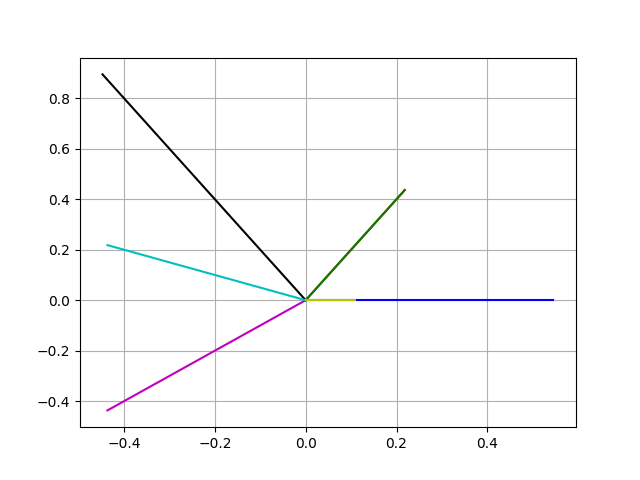

In [143]:
i = 0
x = np.random.randint(1, high=9, size=(1,4,3))
#print 'x: \n', x[i, :, :2]
orientation = np.squeeze(orientationVector(x[i,3,:2].reshape(1, 1, -1), x[i, 2, :2], [10., 10.]))
#print 'orientation: ', orientation
# Calculate relative periodic distances from the com
com = np.array([[1, 2, 3]])
xy_feats = np.random.randint(1, high=9, size=(6,12,2))
temp = periodicDistance(xy_feats, com[0, :2], [10., 10.])
#print 'Distances: ', temp
test, angles = get_angles(xy_feats, com[0, :2], orientation, [10., 10.])
#print 'test: \n', test
print 'angles after: \n', angles[:, 0]*180/np.pi

unit_ort = orientation / np.linalg.norm(orientation, ord=2)
plt.plot([0, unit_ort[0]], [0, unit_ort[1]], 'k')
#plt.plot(test[0,0], test[0,1], 'ro')
colo = ['r', 'g', 'b', 'm', 'c', 'y']
for j in range(len(angles)):
    plt.plot([0, test[j,0]], [0, test[j,1]], c=colo[j])
plt.grid('on')
plt.show()

In [144]:
print angles[:,0]
print np.argsort(angles[:,0])
print angles[1:,0]
print np.argsort(angles[1:,0])

[ 0.92729522  0.92729522  2.03444394  4.39063843  5.6396842   2.03444394]
[0 1 2 5 3 4]
[ 0.92729522  2.03444394  4.39063843  5.6396842   2.03444394]
[0 1 4 2 3]


<IPython.core.display.Javascript object>


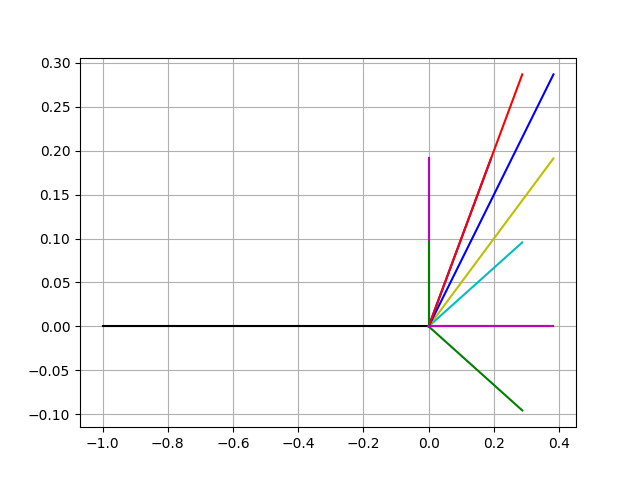

In [100]:
unit_ort = orientation / np.linalg.norm(orientation, ord=2)
plt.plot([0, unit_ort[0]], [0, unit_ort[1]], 'k')
#plt.plot(test[0,0], test[0,1], 'ro')
colo = ['b', 'r', 'g', 'm', 'c', 'y']
for j in range(len(angles)): 
    plt.plot([0, test[j,0]], [0, test[j,1]], c=colo[j%6])
plt.grid('on')
plt.show()

<IPython.core.display.Javascript object>


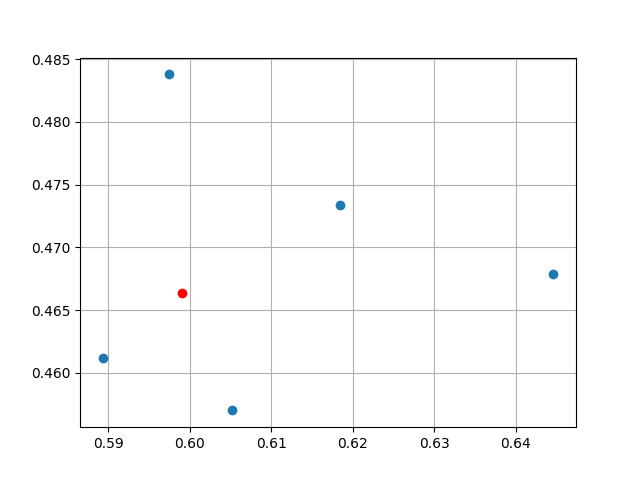

In [30]:
import matplotlib as mp
mp.use('nbagg')
import matplotlib.pyplot as plt
unit_ort = orientation / np.linalg.norm(orientation, ord=2)
#plt.plot(unit_ort[0], unit_ort[1], 'ko')
plt.plot(xy_feats[0,0,0], xy_feats[0,0,1], 'ro')
plt.plot(xy_feats[1:,0,0], xy_feats[1:,0,1], 'o')
plt.grid('on')
plt.show()